In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Channels and names used for recording:  
0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15  
MCLK1	DAT0	DAT1	DAT2	DAT3	DAT4	DAT5	DAT6	DAT7	DAT8	DAT9	DAT10	DAT11	DAT12	DAT13	DAT14

In [30]:
# fpath = "F:\\pp1_data_processing\\dat_bus2_split_contr.txt"
fpath = "F:\\pp1_data_processing\\dat_bus_split.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_min.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_max.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_enhancer_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_contrast_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_bright_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_.txt"
df = pd.read_csv(fpath)

In [139]:
df.columns

Index(['Time[s]', ' MCLK1', ' DAT0', ' DAT1', ' DAT2', ' DAT3', ' DAT4',
       ' DAT5', ' DAT6', ' DAT7', ' DAT8', ' DAT9', ' DAT10', ' DAT11',
       ' DAT12', ' DAT13', ' DAT14'],
      dtype='object')

In [140]:
df.dtypes

Time[s]    float64
 MCLK1       int64
 DAT0        int64
 DAT1        int64
 DAT2        int64
 DAT3        int64
 DAT4        int64
 DAT5        int64
 DAT6        int64
 DAT7        int64
 DAT8        int64
 DAT9        int64
 DAT10       int64
 DAT11       int64
 DAT12       int64
 DAT13       int64
 DAT14       int64
dtype: object

In [31]:
dat0diffs = df[' DAT0'].diff()
chunk_indices_start = dat0diffs.index.to_series().loc[dat0diffs == -1.0] # falling edges
chunk_indices_end = dat0diffs.index.to_series().loc[dat0diffs == 1.0] # rising edges
chunk_indices_start = chunk_indices_start.to_list()
chunk_indices_end = chunk_indices_end.to_list()
print(len(chunk_indices_end), len(chunk_indices_start))
print(chunk_indices_start)
print(chunk_indices_end)

C:\Users\ionca\AppData\Local\Temp\ipykernel_9828\1852024884.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_onechunk.plot(x='Time[s]', y=df_onechunk.columns[1:], subplots=True, ax=ax)


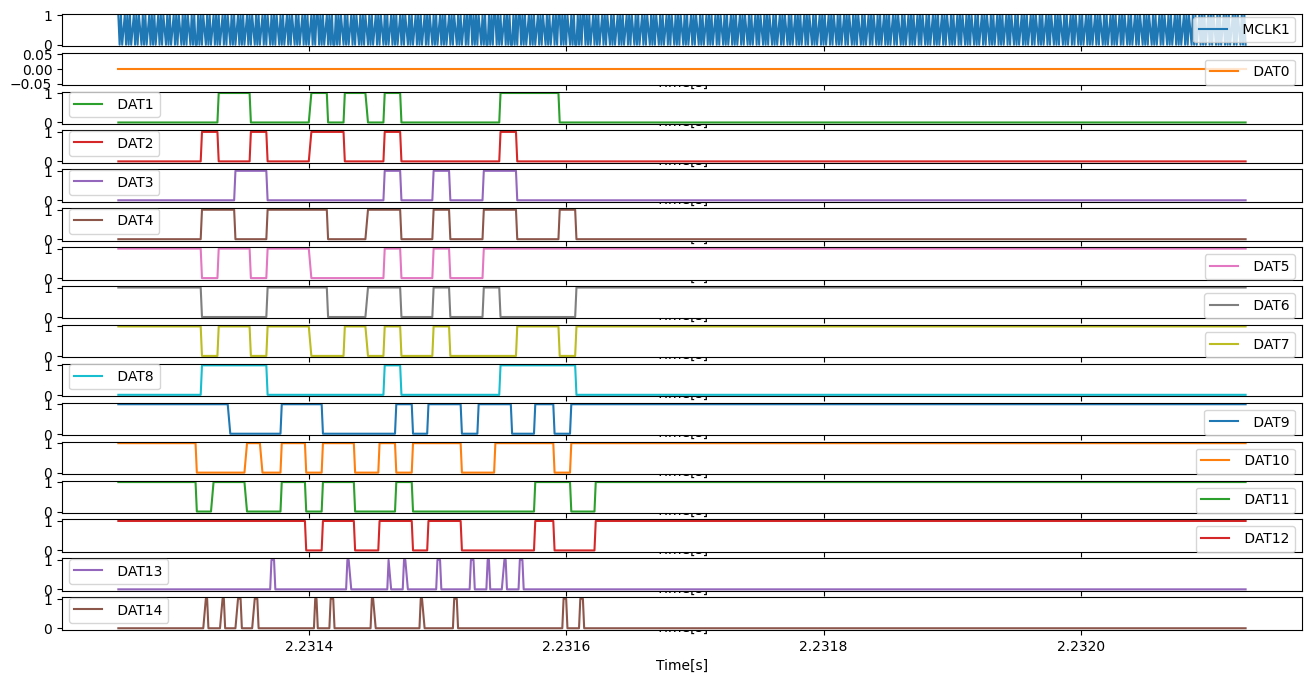

In [33]:
chunknum = 164
df_onechunk = df.iloc[chunk_indices_start[chunknum]:chunk_indices_end[chunknum],].copy()
fig,ax = plt.subplots()
fig.set_size_inches(16,8)
df_onechunk.plot(x='Time[s]', y=df_onechunk.columns[1:], subplots=True, ax=ax)
plt.show()

Assuming the rising edges of DAT13 and DAT14 define when the values of all other DAT lines get stored

In [9]:
dat13dat14rise = df_onechunk[' DAT13'] + df_onechunk[' DAT14']
dat13dat14rise = dat13dat14rise.diff()
dat13dat14rise = dat13dat14rise.loc[dat13dat14rise == 1]
dat13dat14rise = dat13dat14rise.index.to_series()
dat13dat14rise.shape

(20,)

In [44]:
# Get packet timing information
packet_lengths = [] # amount of time DAT0 is low
packet_wait_lengths = [] # amount of time between DAT0 going low and the first byte being transmitted
packet_active_data_lengths = [] # amount of time that the DAT13 and DAT14 lines are in use
packet_inactive_lengths = [] # amount of time that DAT0 remains low after DAT13 and DAT14 are done being used

for chunkstart, chunkend in zip(chunk_indices_start, chunk_indices_end):
    chunkdf = df.iloc[chunkstart:chunkend,]
    
    if chunkdf[' DAT14'].max() == 0:
        continue
    
    # packet length
    packet_length = chunkdf['Time[s]'].iloc[-1] - chunkdf['Time[s]'].iloc[0]
    packet_lengths.append(packet_length)
    
    # dat14 is always the first write to occur in a packet
    dat14diff = chunkdf[' DAT14'].diff()
    dat14_rising_edges = dat14diff.loc[dat14diff == 1]
    # get index of first rising edge on DAT14
    first_dat14_rising_edge = dat14_rising_edges.index.to_list()[0]
    
    # waiting time
    packet_wait = df['Time[s]'].iloc[first_dat14_rising_edge] - chunkdf['Time[s]'].iloc[0]
    packet_wait_lengths.append(packet_wait)
    
    # dat14 is always the last write to occur in a packet
    dat14_falling_edges = dat14diff.loc[dat14diff == -1]
    last_dat14_falling_edge = dat14_falling_edges.index.tolist()[-1]
    
    # active time
    packet_active = df['Time[s]'].iloc[last_dat14_falling_edge] - df['Time[s]'].iloc[first_dat14_rising_edge]
    packet_active_data_lengths.append(packet_active)
    
    # inactive time
    packet_inactive = packet_length - packet_wait - packet_active
    packet_inactive_lengths.append(packet_inactive)

import numpy as np

# print averages
print("Averages:")
print("Packet Length:",np.mean(packet_lengths)*1_000_000, "us")
print("Wait Length:",np.mean(packet_wait_lengths)*1_000_000, "us")
print("Active Length:",np.mean(packet_active_data_lengths)*1_000_000, "us")
print("Inactive Length:",np.mean(packet_inactive_lengths)*1_000_000, "us")

Averages:
Packet Length: 875.5643564356467 us
Wait Length: 70.61386138619136 us
Active Length: 293.90759075903316 us
Inactive Length: 511.04290429042237 us


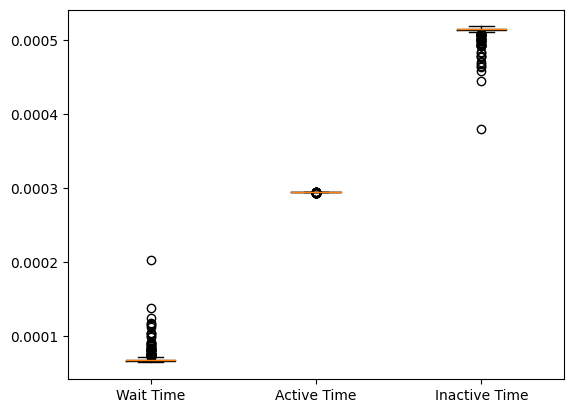

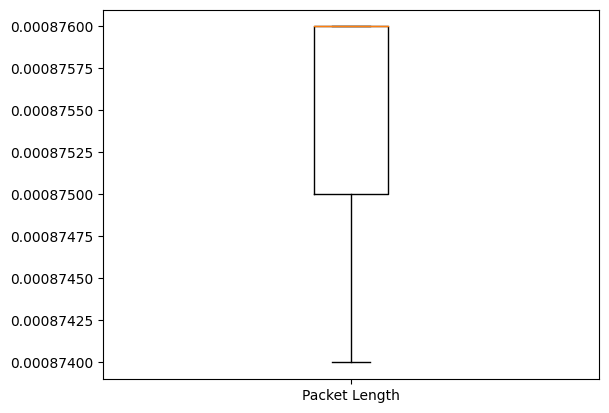

In [48]:
plt.boxplot([packet_wait_lengths, packet_active_data_lengths, packet_inactive_lengths], labels=['Wait Time', 'Active Time', 'Inactive Time'])
plt.show()
plt.boxplot(packet_lengths, labels=['Packet Length'])
plt.show()

In [14]:
chunkdatadf = df_onechunk.loc[dat13dat14rise,]

interesting note that MCLK1 is always low when there is a rising edge on dat13 or dat14 (only evident when data sample rate is >= 10MHz)

In [7]:
def converttodec(row, msbindex=0, lsbindex=-1, reverse=True):
    binlist = row.iloc[msbindex:lsbindex+1].to_list()
    if reverse:
        binlist.reverse()
    nbits = len(binlist)
    dec = 0
    for i in range(nbits):
        dec += binlist[i] * 2**i
    return dec        
    


In [27]:
chunkdatadf['VALUE'] = chunkdatadf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10), axis=1)
chunkdatadf['ADDRESS'] = chunkdatadf.apply(lambda x: converttodec(x, msbindex=11, lsbindex=14, reverse=True), axis=1)
chunkdatadf['BANK'] = chunkdatadf.apply(lambda x: 'A' if x.iloc[15] == 1 else 'B', axis=1)
chunkdatadf.reset_index(inplace=True, drop=True)
# chunkdatadf.sort_values('ADDRESS')
chunkdatadf

,Time[s],MCLK1,DAT0,DAT1,DAT2,DAT3,DAT4,DAT5,DAT6,DAT7,DAT8,DAT9,DAT10,DAT11,DAT12,DAT13,DAT14,VALUE,ADDRESS,BANK
0,2.231309,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,68,9,B
1,2.231322,1,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,149,11,B
2,2.231335,1,0,1,0,1,1,1,0,0,0,0,0,1,1,0,1,184,3,B
3,2.231348,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,1,103,5,B
4,2.231361,1,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,38,1,A
5,2.231394,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,174,8,B
6,2.231407,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,64,7,B
7,2.231420,1,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,130,7,A
8,2.231438,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,20,0,B
9,2.231451,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,255,5,A


# Process the entire timeseries

In [34]:
df_decimaldat1dat14 = pd.DataFrame()
for chunknumber in range(0, len(chunk_indices_start)):
    chunkdf = df.iloc[chunk_indices_start[chunknumber]:chunk_indices_end[chunknumber], :]
    
    dat13dat14rise = chunkdf[' DAT13'] + chunkdf[' DAT14']
    dat13dat14rise = dat13dat14rise.diff()
    dat13dat14rise = dat13dat14rise.loc[dat13dat14rise == 1]
    dat13dat14rise = dat13dat14rise.index.to_series()
    
    chunkdf = chunkdf.loc[dat13dat14rise,]
    
    #df_8bitdat1dat8[len(df_8bitdat1dat8.index),] = chunkdf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10), axis=1)
    vals = chunkdf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10, reverse=True), axis=1)
    if vals.empty:
        continue
    vals = vals.reset_index()
    vals = vals.drop(columns='index')

    vals = vals.T
    df_decimaldat1dat14 = pd.concat([df_decimaldat1dat14, vals], ignore_index=True)
    # df_8bitdat1dat8.insert(chunknumber, chunknumber, vals)
    

# df_8bitdat1dat8 = df_8bitdat1dat8.T
# oldcols = df_8bitdat1dat8.columns.tolist()
# newcols = ['val'+str(i) for i in range(20)]
# colmapper = dict(zip(oldcols, newcols))
# df_8bitdat1dat8.rename(colmapper, axis='columns', inplace=True)
# df_8bitdat1dat8.reset_index(inplace=True)
# df_8bitdat1dat8.drop(columns='index', inplace=True)
if df_decimaldat1dat14.shape[1] > 20:
    df_decimaldat1dat14.drop(columns=20, inplace=True)
    
df_decimaldat1dat14

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
1,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
2,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
3,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
4,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
299,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
300,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
301,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0


C:\Users\ionca\AppData\Local\Temp\ipykernel_9828\1126491182.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_decimaldat1dat14.plot(use_index=True,subplots=True, ax=ax) # show all


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

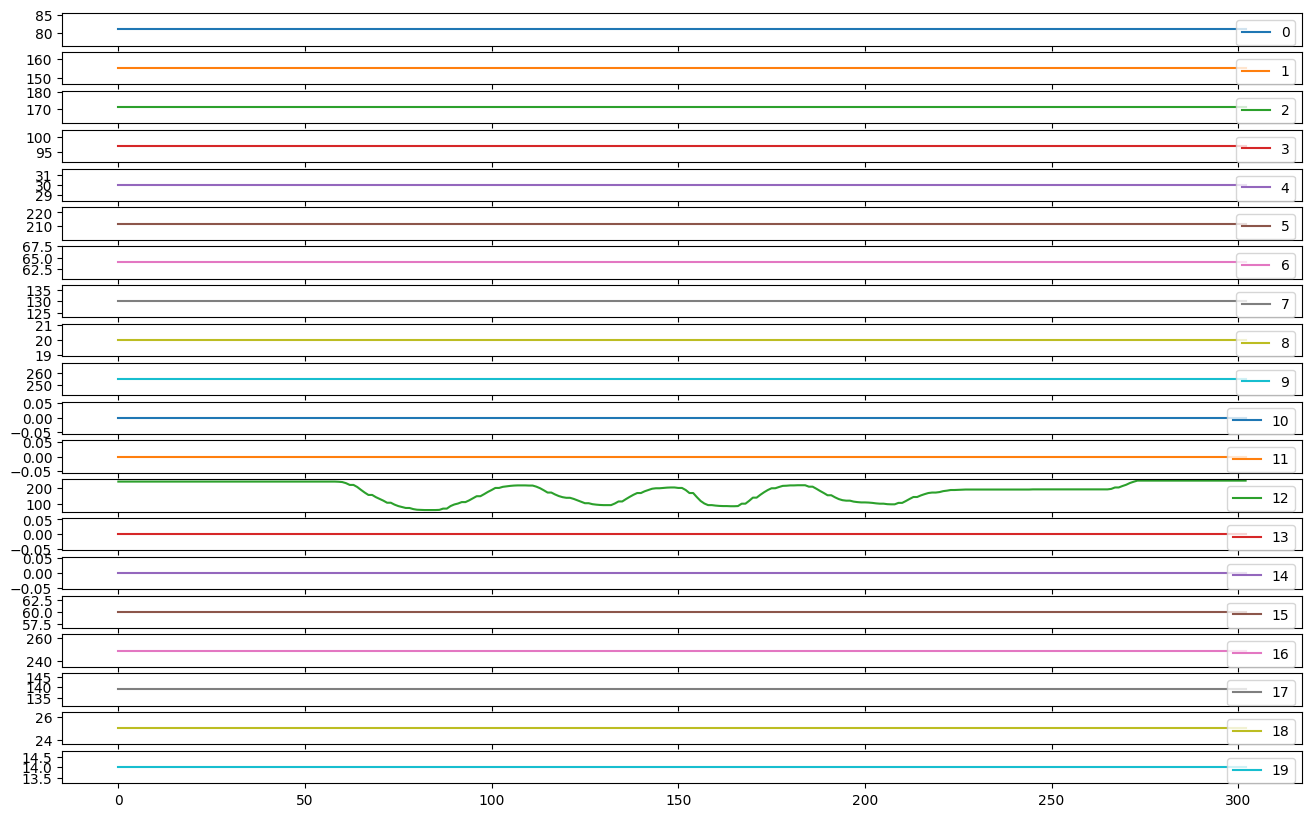

In [35]:
fig,ax = plt.subplots()
fig.set_size_inches(16, 10)
# df_decimaldat1dat14[[0,1,2,3,4,18,19]].plot(use_index=True,subplots=True, ax=ax) # use for color adjustments
# df_decimaldat1dat14[[14,15]].plot(use_index=True,subplots=True, ax=ax) # use for enhancer adjustments
# df_decimaldat1dat14[[5,16,17]].plot(use_index=True,subplots=True, ax=ax) # use for contrast
# df_decimaldat1dat14[[16]].plot(use_index=True,subplots=True, ax=ax) 
df_decimaldat1dat14.plot(use_index=True,subplots=True, ax=ax) # show all